## For imports to work in jupyter notebook

In [41]:
import os
import sys
directory_path = os.path.abspath(os.path.join('..'))
if directory_path not in sys.path:
    sys.path.append(directory_path)

# Dataset name

In [42]:
dataset = os.path.basename(os.getcwd())

# Imports

In [43]:
# data manipulation
import pandas as pd
import numpy as np

# data viz
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

# apply some cool styling
plt.style.use("ggplot")
rcParams['figure.figsize'] = (12, 6)
from Data import PREPROCESS_FUNCTIONS

# Data import

In [44]:
raw_data = pd.read_csv(os.path.join(os.getcwd(), f"{dataset}.data"))
raw_data.head()

,class,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat
0,no-recurrence-events,30-39,premeno,30-34,0-2,no,3,left,left_low,no
1,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,right,right_up,no
2,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,left,left_low,no
3,no-recurrence-events,60-69,ge40,15-19,0-2,no,2,right,left_up,no
4,no-recurrence-events,40-49,premeno,0-4,0-2,no,2,right,right_low,no


# Data analysys

In [45]:
print(f"shape: {raw_data.shape}")
raw_data.info()

shape: (286, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286 entries, 0 to 285
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   class        286 non-null    object
 1   age          286 non-null    object
 2   menopause    286 non-null    object
 3   tumor-size   286 non-null    object
 4   inv-nodes    286 non-null    object
 5   node-caps    286 non-null    object
 6   deg-malig    286 non-null    int64 
 7   breast       286 non-null    object
 8   breast-quad  286 non-null    object
 9   irradiat     286 non-null    object
dtypes: int64(1), object(9)
memory usage: 22.5+ KB


Mamy do czynienia ze zbiorem 286 rekordów, z 9 atrybutami dyskretnymi. Niektóre z nich - takie jak wiek, czy rozmiar guza jesteśmy w stanie zamienić na wartość liczbową a następnie znormalizować, by poprawić uczenie modelu.

In [46]:
raw_data.duplicated().sum()

14

Mamy 14 rekordów zduplokowanych. Jest to całkiem dużo, biorąc pod uwagę to, że mamy jedynie 286 wierszy z danymi, ale nie powinno to stanowić dużego problemu w trenowaniu modeli.

In [47]:
raw_data.value_counts('class')

class
no-recurrence-events    201
recurrence-events        85
dtype: int64

In [48]:
recursive_events_percentage = raw_data.value_counts('class')[1] / \
    (raw_data.value_counts('class')[0] + raw_data.value_counts('class')[1])
print(f'recursive events percentage: {recursive_events_percentage}')

recursive events percentage: 0.2972027972027972


<Axes: title={'center': 'Class distribution'}, xlabel='Class', ylabel='Count'>

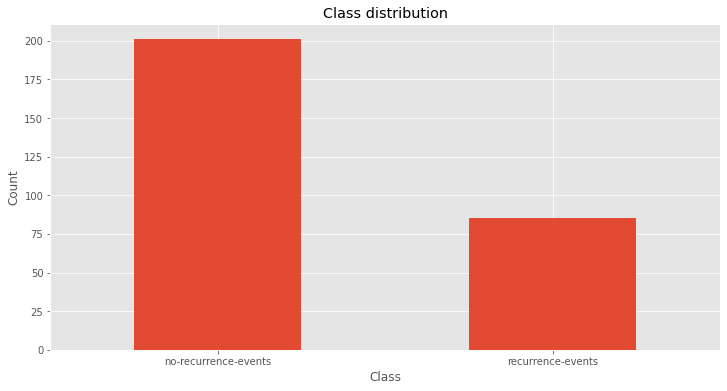

In [49]:
# Plot the distribution of the class attribute
raw_data['class'].value_counts().plot(kind='bar', title='Class distribution', xlabel='Class', ylabel='Count', rot=0)

Widzimy znaczną dysproporcję w zbiorze danych. Stosunek osób zdiagnozowanych jako zagrożonych do osób zdrowych wynosi 1 do 2.36 - dysproporcja jest zauważalna. Przy uczeniu niektórych modeli należy poświęcić czas na odpowiednie rozwiązanie tego problemu - dobieranie przypadków uczących zważając na dysproporcję - np. WeightedRandomSampler.

In [50]:
for name, series in raw_data.iteritems():
    print(name, series.unique())

class ['no-recurrence-events' 'recurrence-events']
age ['30-39' '40-49' '60-69' '50-59' '70-79' '20-29']
menopause ['premeno' 'ge40' 'lt40']
tumor-size ['30-34' '20-24' '15-19' '0-4' '25-29' '50-54' '10-14' '40-44' '35-39'
 '5-9' '45-49']
inv-nodes ['0-2' '6-8' '9-11' '3-5' '15-17' '12-14' '24-26']
node-caps ['no' 'yes' '?']
deg-malig [3 2 1]
breast ['left' 'right']
breast-quad ['left_low' 'right_up' 'left_up' 'right_low' 'central' '?']
irradiat ['no' 'yes']


Widać, że w niektórych z kolumn ['node-caps', 'breast-quad'] występują 'missing values'. Jest ich zbyt mało, by poddać głębszej analizie powód braków wartości - na potrzeby naszego projektu możemy przyjąć, że są to wartości Missing Completly At Random - dane są niekompletne w sposób całkowicie losowy. W procesie preprocessingu zastąpimy brakujące wartości najczęściej występującą wartością odpowiadającej kolumny w zbiorze danych.

## Wizualizacja częstości występowania atrybutów

C:\Users\User\AppData\Local\Temp/ipykernel_38184/3888696405.py:5: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout(pad=40.0)


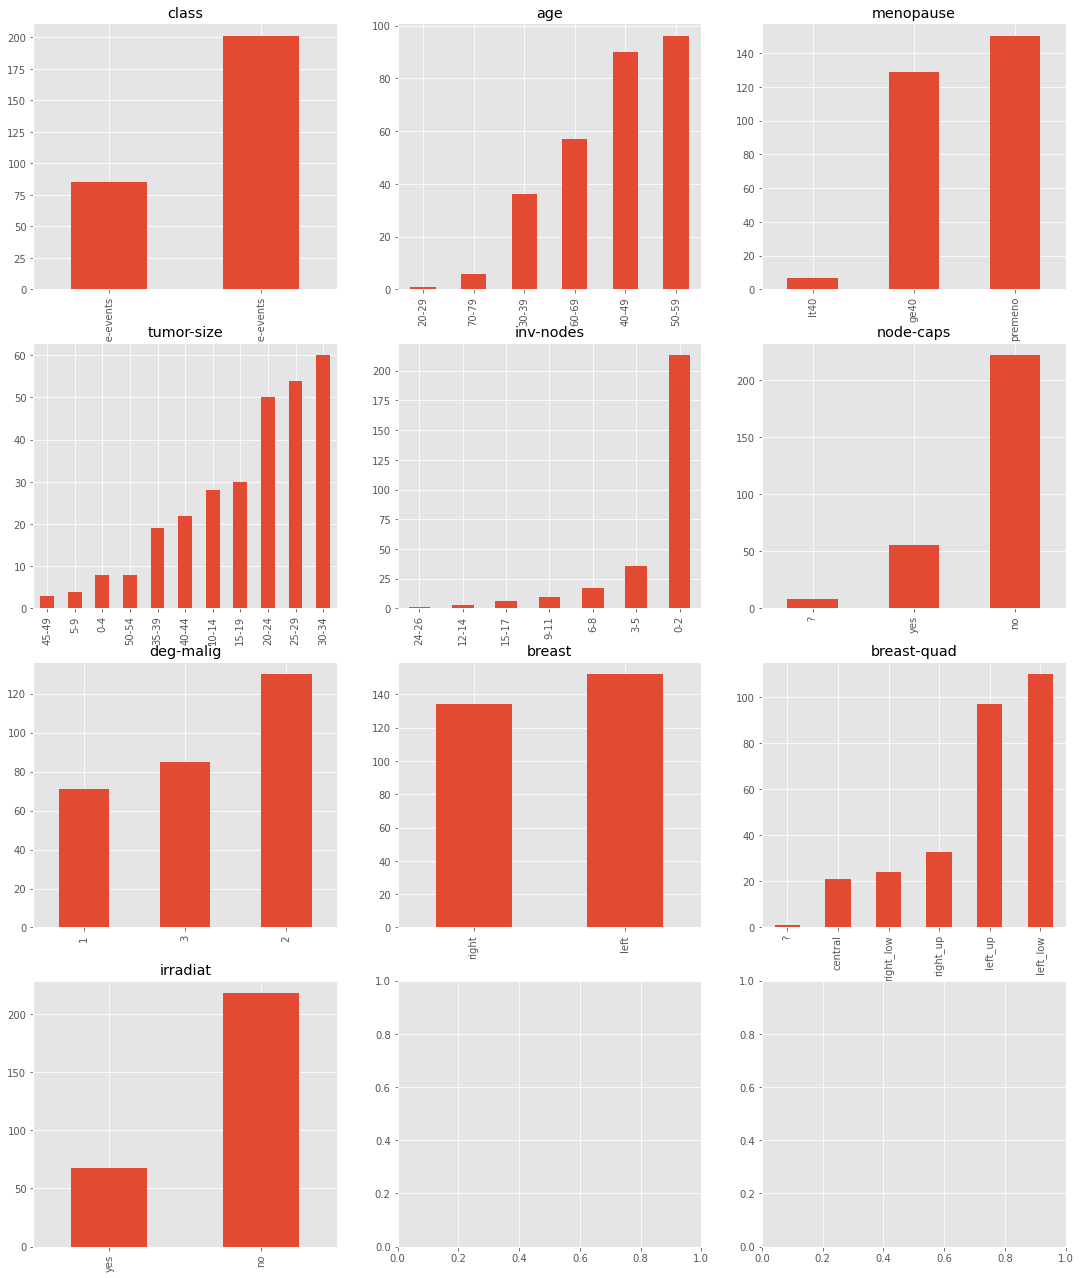

In [51]:
from math import ceil
from copy import deepcopy

fig, axes = plt.subplots(ceil(len(raw_data.columns)/3), 3)
fig.tight_layout(pad=40.0)
fig.set_size_inches(18.5, 22.5)

row = 0
col = 0
for name, values in deepcopy(raw_data).iteritems():
  axes[row, col].set_title(name)
  values.value_counts().sort_values(ascending=True).plot(kind='bar', ax=axes[row, col])

  col += 1
  if col %3 == 0:
    row += 1
    col = 0

Wizualizacja atrybutów pozwoliła nam lepiej zrozumieć dystrybucje ich wartości w zbiorze danych. Wartości ich są albowiem niezbalansowane. W przypadku np. kolumny reprezentującej wiek pacjenta - przeważająca część pacjentów była w zakresie 40-60 lat. Bardzo ubogi jest zakres młodych pacjentek w wieku od 20 do 40 lat, co może wpłynąć na jakość otrzymywanych modeli, jeżeli w danych testowych znajdzie się dużo pacjentek z tego zakresu wieku. Najsilniej widoczna dysproporcja jest zauważalna na wykresie inv-nodes. Z domeny medycznej - atrybut ten oznacza ilość pachowych węzłów chłonnych zawierających przerzuty raka piersi widoczne w badaniu histopatologicznym. Widzimy, że znaczna część pacjentów miała jedynie 0-2 takich węzłów, stąd informacja że dane dotyczą raczej osób we wczesnych fazach raka piersi.

### Preprocessing

Wykonajmy czynności związane ze wstępną obróbką danych - normalizacją atrybutów, które da się zapisać jako ciągłe oraz zakodowaniu za pomocą one-hot-encoding atrybutów dyskretnych. Zastąpimy również brakujące dane wartością uśrednioną. Klasom przydzielimy odpowiednie etykiety - 0 jako rekord reprezentujący osobę zdrową i 1 - rekord reprezentujący osobę w grupe zagrożenia.

In [52]:
preprocessed_data = PREPROCESS_FUNCTIONS[dataset](raw_data=raw_data)
preprocessed_data.head()

,class,age,tumor-size,inv-nodes,node-caps,deg-malig,irradiat,menopause_ge40,menopause_lt40,menopause_premeno,breast_left,breast_right,breast-quad_central,breast-quad_left_low,breast-quad_left_up,breast-quad_right_low,breast-quad_right_up
0,0,0.2,0.6,0.0,0,3,0,0,0,1,1,0,0,1,0,0,0
1,0,0.4,0.4,0.0,0,2,0,0,0,1,0,1,0,0,0,0,1
2,0,0.4,0.4,0.0,0,2,0,0,0,1,1,0,0,1,0,0,0
3,0,0.8,0.3,0.0,0,2,0,1,0,0,0,1,0,0,1,0,0
4,0,0.4,0.0,0.0,0,2,0,0,0,1,0,1,0,0,0,1,0


In [53]:
preprocessed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286 entries, 0 to 285
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   class                  286 non-null    int64  
 1   age                    286 non-null    float64
 2   tumor-size             286 non-null    float64
 3   inv-nodes              286 non-null    float64
 4   node-caps              286 non-null    int64  
 5   deg-malig              286 non-null    int64  
 6   irradiat               286 non-null    int64  
 7   menopause_ge40         286 non-null    uint8  
 8   menopause_lt40         286 non-null    uint8  
 9   menopause_premeno      286 non-null    uint8  
 10  breast_left            286 non-null    uint8  
 11  breast_right           286 non-null    uint8  
 12  breast-quad_central    286 non-null    uint8  
 13  breast-quad_left_low   286 non-null    uint8  
 14  breast-quad_left_up    286 non-null    uint8  
 15  breast

In [54]:
for name, series in preprocessed_data.iteritems():
    print(name, series.unique())

class [0 1]
age [0.2 0.4 0.8 0.6 1.  0. ]
tumor-size [0.6 0.4 0.3 0.  0.5 1.  0.2 0.8 0.7 0.1 0.9]
inv-nodes [0.    0.25  0.375 0.125 0.625 0.5   1.   ]
node-caps [0 1]
deg-malig [3 2 1]
irradiat [0 1]
menopause_ge40 [0 1]
menopause_lt40 [0 1]
menopause_premeno [1 0]
breast_left [1 0]
breast_right [0 1]
breast-quad_central [0 1]
breast-quad_left_low [1 0]
breast-quad_left_up [0 1]
breast-quad_right_low [0 1]
breast-quad_right_up [0 1]


Preprocessing danych przebiegł pomyślnie. Atrybuty dyskretne zostały zastąpione przez one-hot-encoding, a atrybuty, które dało się zapisać jako ciągłe uległy normalizacji. Pozbyliśmy się również wartości brakujących.

## Zależności pomiędzy atrybutami

Jako, że wszystkie atrybuty łącznie z klasą są dyskretne, zajmiemy się analizą zależności na podstawie współczynników korelacji między nimi.

<Axes: >

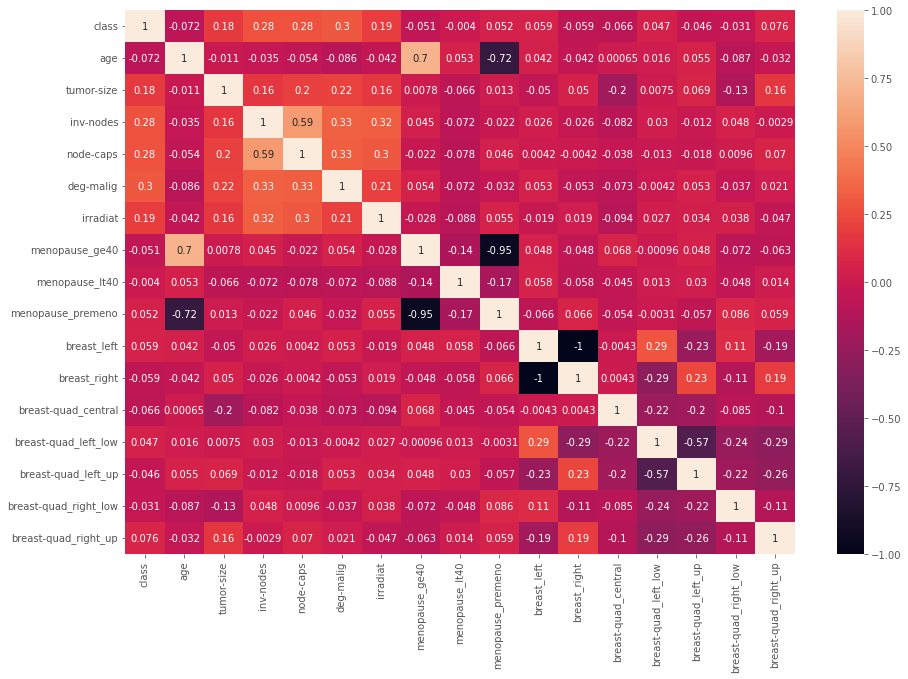

In [55]:
CorrMat = preprocessed_data.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(CorrMat, annot=True)
# plot 

Z powyższego wykresu można odczytać informacje oczywiste - takie jak to, że gdy u pacjenta występuje guz w lewej piersi - to nie występuje on w prawej. Oczywiście z medycznego punktu widzenia, taka możliwość istnieje, ale nasz zbiór danych jest mocno zubożony i dotyczy pacjentek których badana była tylko jedna pierś. Analogicznie, widzimy silną zależność odwrotną pomiędzy menopause_premeno a wiekiem oraz menopause_ge40. Ma to sens, ponieważ przedwczesna menopauza oznacza, że pacjentka musiała być w młodym wieku i na pewno nie mogła przechodzić menopauzy w wieku >= 40 lat. Pozostają inne zależności takie jak breast_left i umiejscowienie guza w którymś miejscu lewej piersi, ale analiza tych zależności nic nie wniesie do projektu.

Co może nas faktycznie interesować, to to że istnieje silna zależność między klasą, a inv-nodes oraz klasą a node-caps, a dodatkowo te dwa atrybuty są silnie skorelowane ze sobą. Mogą one okazać się kluczowe dla naszych modeli i są warte dalszej analizy.

<Axes: xlabel='inv-nodes', ylabel='node-caps'>

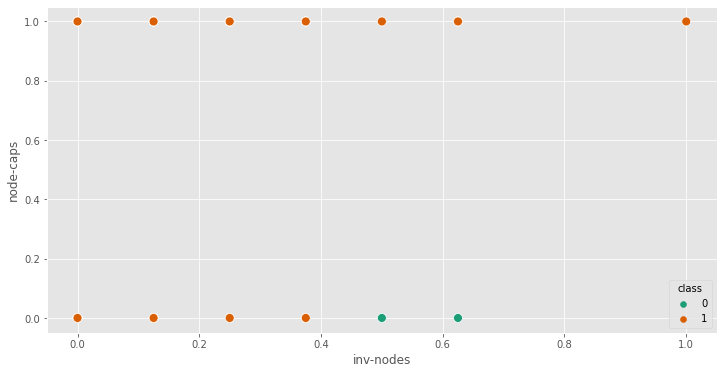

In [56]:
sns.scatterplot(x="inv-nodes", y="node-caps", hue="class", data=preprocessed_data, palette="Dark2", s=80)

Widzimy, że osoby zdrowe nie posiadają node-caps. Jest to zatem istotny dla potencjalnych modeli atrybut.

Oprócz node-caps i inv-nodes, wysoko skorelowane z klasą atrybuty to tumor-size, deg-malig oraz irradiat. Warto poddać głębszej analizie zależności między tymi atrybutami.

<Figure size 864x432 with 0 Axes>

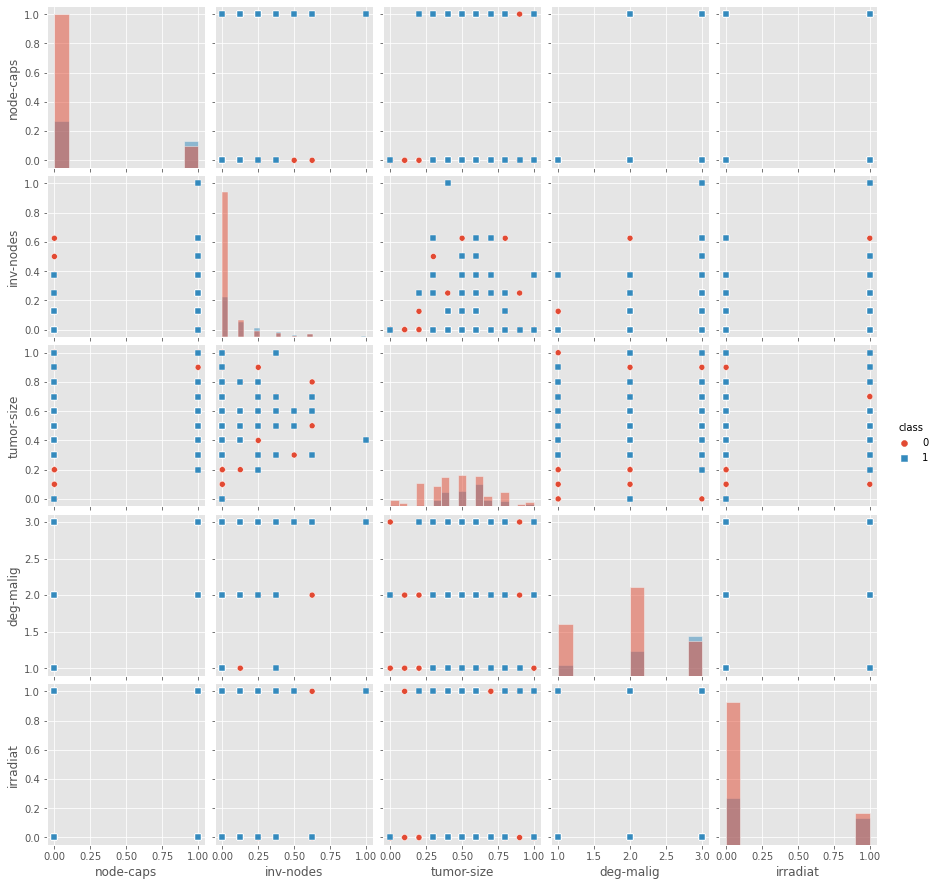

In [57]:
plt.figure()
cols_to_plot = ['node-caps', 'inv-nodes', 'tumor-size', 'deg-malig', 'irradiat', 'class']
sns.pairplot(preprocessed_data[cols_to_plot], hue ="class", markers=["o", "s"], diag_kind="hist")
plt.show()

Z powyższego wykresu nie wynika żadna nowa, ciekawa dla naszego problemu zależność.

## Porównanie liczności klas z wartościami silnie skorelowanych z nią atrybutów

C:\Users\User\AppData\Local\Temp/ipykernel_38184/3838156766.py:2: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout(pad=40.0)


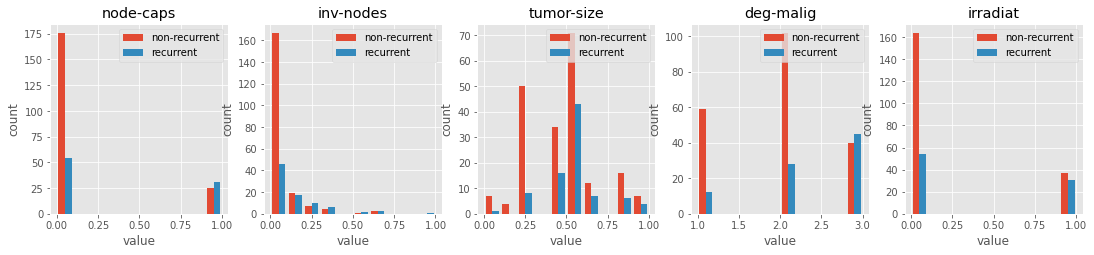

In [71]:
fig, axes = plt.subplots(1, 5)
fig.tight_layout(pad=40.0)
fig.set_size_inches(18.5, 3.5)

cols_to_plot = ['node-caps', 'inv-nodes', 'tumor-size', 'deg-malig', 'irradiat']
class_0 = preprocessed_data[preprocessed_data['class'] == 0]
class_1 = preprocessed_data[preprocessed_data['class'] == 1]

for i, col in enumerate(cols_to_plot):
  axes[i].hist(x=[class_0[col], class_1[col]])
  axes[i].set_title(col)
  axes[i].set(xlabel='value', ylabel='count')
  axes[i].legend(('non-recurrent', 'recurrent') )

plt.show()

Z powyższego wykresu widać, że atrybuty tumor-size oraz deg-malig ukladają się zgodnie z rozkładem normalnym. Co więcej, deg-malig = degree of maligence - stopień złośliwości, pokazuje nam, że najczęściej spotykanym w danych poziomem złośliwości był poziom 2, i wraz z jego wzrostem rośnie liczba pacjentek znajdujących się w grupie ryzyka. Najliczniejszą grupę pacjentek pod względem atrybutu inv-nodes stanowią pacjentki z liczbą węzłów chłonnych z zakresu od 0 do 2. Wraz ze wzrostem tej liczby, maleje liczba pacjentek w grupie zagrożenia. Co do poprzednich atrybutuów, rozłożenie klas jest zbalansowane i zgodne z rozkładem atrybutu.

## Dodatkowe uwagi

- W internecie znaleźliśmy informacje o tym, że breast-quadrants zostały niepoprawnie przypisane do 'prawej piersi' pomimo tego, że dotyczyły one lewej piersi. W związku z tym, że dane są zakłamane i nie są szczególnie istotne dla naszego modelu, w ostatecznej wersji zdecydujemy się na pominięcie tych atrybutów w uczeniu modeli.

## Wnioski z analizy
- posiadamy dane 286 osób, jest to mało aby nauczyć dobry klasyfikator, ale nie będziemysię w tym projekcie na samym uczeniu dobrych klasyfikatorów, a na wizualizacji miar jakości modeli.
- Klasą większościową są osoby u których nie wystąpiły zdarzenia rekurencyjne (no-recursive-events), stanowią 70% całego datasetu. Reszta to osoby u których wystąpiły zdarzenia rekurencyjne.
- Udało nam się zauważyć silną korelację między wiekiem a posiadaniem menopauzy ge_40 oraz niski wiek jest skorelowany z posiadaniem menopauzy premeno.
- Najbardziej skorelowane z atrybutem klasy są: deg-malig, node-caps, inv-nodes. Jest to jednak korelacja na poziomie 0.3, dodatkowo trzeba pamiętać że korelacja nie oznacza przyczynowości.
- Do trenowania niektórych modeli wymagane będzie użycie Samplera, ze względu na silną przewagę zdrowych pacjentów w zbiorze danych.
- Modele trenowane będą przy użyciu jedynie najbardziej znaczących atrybutów.
